In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from spektral.data.loaders import SingleLoader
from spektral.datasets.citation import Citation
from spektral.layers import GCNConv
from spektral.models import GNNExplainer
from spektral.models.gcn import GCN
from spektral.transforms import AdjToSpTensor, LayerPreprocess
from spektral.utils import gcn_filter

In [4]:
# Config
learning_rate = 1e-2
seed = 0
epochs = 50
patience = 10
data = "cora"
tf.random.set_seed(seed=seed)  # make weight initialization reproducible

In [5]:
# Load data
dataset = Citation(data, normalize_x=True, transforms=[LayerPreprocess(GCNConv)])

Pre-processing node features


c:\Users\Shrey\OneDrive\Documents\GitHub\msci-project\.venv\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [6]:
# We convert the binary masks to sample weights so that we can compute the
# average loss over the nodes (following original implementation by
# Kipf & Welling)
def mask_to_weights(mask):
    return mask.astype(np.float32) / np.count_nonzero(mask)

In [7]:
weights_tr, weights_va, weights_te = (
    mask_to_weights(mask)
    for mask in (dataset.mask_tr, dataset.mask_va, dataset.mask_te)
)

In [8]:
model = GCN(n_labels=dataset.n_labels)
model.compile(
    optimizer=Adam(learning_rate),
    loss=CategoricalCrossentropy(reduction="sum"),
    weighted_metrics=["acc"],
)

In [9]:
# Train model
loader_tr = SingleLoader(dataset, sample_weights=weights_tr)
loader_va = SingleLoader(dataset, sample_weights=weights_va)

model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)],
)

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 1.9544 - acc: 0.0786 - val_loss: 1.9504 - val_acc: 0.2640
Epoch 2/50
1/1 [==============================] - 0s 113ms/step - loss: 1.9476 - acc: 0.3571 - val_loss: 1.9464 - val_acc: 0.4940
Epoch 3/50
1/1 [==============================] - 0s 128ms/step - loss: 1.9416 - acc: 0.5786 - val_loss: 1.9420 - val_acc: 0.5840
Epoch 4/50
1/1 [==============================] - 0s 113ms/step - loss: 1.9336 - acc: 0.6857 - val_loss: 1.9372 - val_acc: 0.6160
Epoch 5/50
1/1 [==============================] - 0s 114ms/step - loss: 1.9277 - acc: 0.7357 - val_loss: 1.9325 - val_acc: 0.6360
Epoch 6/50
1/1 [==============================] - 0s 110ms/step - loss: 1.9189 - acc: 0.7357 - val_loss: 1.9279 - val_acc: 0.6300
Epoch 7/50
1/1 [==============================] - 0s 116ms/step - loss: 1.9103 - acc: 0.7500 - val_loss: 1.9234 - val_acc: 0.6380
Epoch 8/50
1/1 [==============================] - 0s 116ms/step - loss: 1.9046 - acc: 0.7571 

In [10]:
# Set up explainer
dataset.apply(AdjToSpTensor())
x_exp, a_exp = dataset[0].x, dataset[0].a
explainer = GNNExplainer(model, preprocess=gcn_filter, verbose=True)

n_hops was automatically inferred to be 2


In [11]:
# Explain prediction for one node
node_idx = 1000
adj_mask, feat_mask = explainer.explain_node(x=x_exp, a=a_exp, node_idx=node_idx)

pred_loss: 1.831010103225708, a_size_loss: 0.687591016292572, a_entropy_loss: 0.06930524855852127, smoothness_loss: [[0.]], x_size_loss: 71.65461730957031, x_entropy_loss: 0.06918551027774811
pred_loss: 1.8304520845413208, a_size_loss: 0.6843104362487793, a_entropy_loss: 0.06930411607027054, smoothness_loss: [[0.]], x_size_loss: 71.29733276367188, x_entropy_loss: 0.06918429583311081
pred_loss: 1.8298996686935425, a_size_loss: 0.6810058355331421, a_entropy_loss: 0.06930055469274521, smoothness_loss: [[0.]], x_size_loss: 70.9400634765625, x_entropy_loss: 0.06918061524629593
pred_loss: 1.8293530941009521, a_size_loss: 0.6776907444000244, a_entropy_loss: 0.06929456442594528, smoothness_loss: [[0.]], x_size_loss: 70.58282470703125, x_entropy_loss: 0.06917444616556168
pred_loss: 1.8288121223449707, a_size_loss: 0.6743694543838501, a_entropy_loss: 0.06928613036870956, smoothness_loss: [[0.]], x_size_loss: 70.22563934326172, x_entropy_loss: 0.06916579604148865
pred_loss: 1.8282768726348877, a_

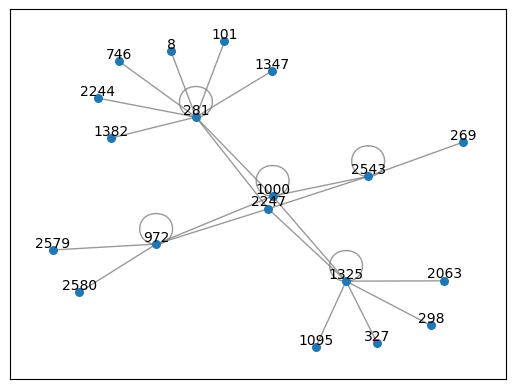

In [13]:
# Plot the result
G = explainer.plot_subgraph(adj_mask, feat_mask, node_idx)